In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", module="IPython")

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

print(f"Root dir: {root_dir}")

# Add the root directory to the `PYTHONPATH` 
if root_dir not in sys.path:
    sys.path.append(root_dir)
    print(f"Added the following directory to the PYTHONPATH: {root_dir}")

# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Root dir: /Users/kcah/Documents/code-repo/air-quality-prediction
Added the following directory to the PYTHONPATH: /Users/kcah/Documents/code-repo/air-quality-prediction
HopsworksSettings initialized!


<span style="font-width:bold; font-size: 3rem; color:#333;">- Part 01: Feature Backfill for Air Quality Data</span>


### <span style='color:#ff5f27'> 📝 Imports

In [3]:
import datetime
import requests
import pandas as pd
import hopsworks
from mlfs.airquality import util
import datetime
from pathlib import Path
import json
import re
import os
import warnings
warnings.filterwarnings("ignore")

---

In [4]:
project = hopsworks.login()

2025-11-05 08:47:33,479 INFO: Initializing external client
2025-11-05 08:47:33,480 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-05 08:47:34,988 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279136


In [5]:
today = datetime.date.today()

csv_file=f"{root_dir}/data/helsinki-air-quality.csv"
util.check_file_path(csv_file)

# taken from ~/.env. You can also replace settings.AQICN_API_KEY with the api key value as a string "...."
if settings.AQICN_API_KEY is None:
    print("You need to set AQICN_API_KEY either in this cell or in ~/.env")
    sys.exit(1)

AQICN_API_KEY = settings.AQICN_API_KEY.get_secret_value() 
aqicn_url = settings.AQICN_URL
country = settings.AQICN_COUNTRY
city = settings.AQICN_CITY
street = settings.AQICN_STREET
# If this API call fails (it fails in a github action), then set longitude and latitude explicitly - comment out next line
# latitude, longitude = util.get_city_coordinates(city)
# Uncomment this if API call to get longitude and latitude
latitude = "60.1733244"
longitude = "24.9410248"

print(f"Found AQICN_API_KEY: {AQICN_API_KEY}")

secrets = hopsworks.get_secrets_api()
# Replace any existing secret with the new value
secret = secrets.get_secret("AQICN_API_KEY")
if secret is not None:
    secret.delete()
    print("Replacing existing AQICN_API_KEY")

secrets.create_secret("AQICN_API_KEY", AQICN_API_KEY)

File successfully found at the path: /Users/kcah/Documents/code-repo/air-quality-prediction/data/helsinki-air-quality.csv
Found AQICN_API_KEY: ec3d14d748112fe5c0e14d9f701eeb5c1a53be59
Replacing existing AQICN_API_KEY
Secret created successfully, explore it at https://c.app.hopsworks.ai:443/account/secrets


Secret('AQICN_API_KEY', 'PRIVATE')

### Validate that the AQICN_API_KEY you added earlier works

The cell below should print out something like:

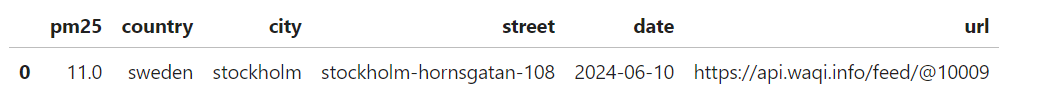

In [6]:
try:
    aq_today_df = util.get_pm25(aqicn_url, country, city, street, today, AQICN_API_KEY)
except hopsworks.RestAPIError:
    print("It looks like the AQICN_API_KEY doesn't work for your sensor. Is the API key correct? Is the sensor URL correct?")

aq_today_df.head()

,pm25,country,city,street,date,url
0,8.0,finland,helsinki,kluuvi,2025-11-05,https://api.waqi.info/feed/@5717


## Read your CSV file into a DataFrame

The cell below will read up historical air quality data as a CSV file into a Pandas DataFrame

In [7]:
df = pd.read_csv(csv_file,  parse_dates=['date'], skipinitialspace=True)
df

,date,pm25,pm10,o3,no2,so2
0,2025-11-01,21.0,6.0,14.0,3.0,NaN
1,2025-11-02,19.0,8.0,23.0,6.0,NaN
2,2025-11-03,23.0,8.0,17.0,7.0,NaN
3,2025-11-04,13.0,NaN,NaN,NaN,NaN
4,2025-10-01,33.0,23.0,22.0,12.0,NaN
...,...,...,...,...,...,...
4169,2016-01-05,NaN,12.0,11.0,9.0,NaN
4170,2015-10-04,NaN,19.0,19.0,21.0,NaN
4171,2015-11-10,NaN,17.0,17.0,18.0,NaN
4172,2014-12-31,NaN,17.0,21.0,9.0,NaN


## Data cleaning


### Rename columns if needed and drop unneccessary columns

We want to have a DataFrame with 2 columns - `date` and `pm25` after this cell below:

## Check the data types for the columns in your DataFrame

 * `date` should be of type   datetime64[ns] 
 * `pm25` should be of type float64

In [8]:
df_aq = df[['date', 'pm25']]
df_aq['pm25'] = df_aq['pm25'].astype('float32')

df_aq

,date,pm25
0,2025-11-01,21.0
1,2025-11-02,19.0
2,2025-11-03,23.0
3,2025-11-04,13.0
4,2025-10-01,33.0
...,...,...
4169,2016-01-05,NaN
4170,2015-10-04,NaN
4171,2015-11-10,NaN
4172,2014-12-31,NaN


In [9]:
# Cast the pm25 column to be a float32 data type
df_aq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4174 entries, 0 to 4173
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4174 non-null   datetime64[ns]
 1   pm25    4158 non-null   float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 49.0 KB


## Drop any rows with missing data
It will make the model training easier if there is no missing data in the rows, so we drop any rows with missing data.

In [10]:
df_aq.dropna(inplace=True)
df_aq

,date,pm25
0,2025-11-01,21.0
1,2025-11-02,19.0
2,2025-11-03,23.0
3,2025-11-04,13.0
4,2025-10-01,33.0
...,...,...
4153,2014-06-26,45.0
4154,2014-06-27,35.0
4155,2014-06-28,31.0
4156,2014-06-29,36.0


## Add country, city, street, url to the DataFrame

Your CSV file may have many other air quality measurement columns. We will only work with the `pm25` column.

We add the columns for the country, city, and street names that you changed for your Air Quality sensor.

We also want to make sure the `pm25` column is a float32 data type.

In [11]:
# Your sensor may have columns we won't use, so only keep the date and pm25 columns
# If the column names in your DataFrame are different, rename your columns to `date` and `pm25`
df_aq['country']=country
df_aq['city']=city
df_aq['street']=street
df_aq['url']=aqicn_url
df_aq

,date,pm25,country,city,street,url
0,2025-11-01,21.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717
1,2025-11-02,19.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717
2,2025-11-03,23.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717
3,2025-11-04,13.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717
4,2025-10-01,33.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717
...,...,...,...,...,...,...
4153,2014-06-26,45.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717
4154,2014-06-27,35.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717
4155,2014-06-28,31.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717
4156,2014-06-29,36.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717


In [12]:
df_aq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4158 entries, 0 to 4157
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     4158 non-null   datetime64[ns]
 1   pm25     4158 non-null   float32       
 2   country  4158 non-null   object        
 3   city     4158 non-null   object        
 4   street   4158 non-null   object        
 5   url      4158 non-null   object        
dtypes: datetime64[ns](1), float32(1), object(4)
memory usage: 211.1+ KB


---

## <span style='color:#ff5f27'> 🌦 Loading Weather Data from [Open Meteo](https://open-meteo.com/en/docs)

## Download the Historical Weather Data

https://open-meteo.com/en/docs/historical-weather-api#hourly=&daily=temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant

We will download the historical weather data for your `city` by first extracting the earliest date from your DataFrame containing the historical air quality measurements.

We will download all daily historical weather data measurements for your `city` from the earliest date in your air quality measurement DataFrame. It doesn't matter if there are missing days of air quality measurements. We can store all of the daily weather measurements, and when we build our training dataset, we will join up the air quality measurements for a given day to its weather features for that day. 

The weather features we will download are:

 * `temperature (average over the day)`
 * `precipitation (the total over the day)`
 * `wind speed (average over the day)`
 * `wind direction (the most dominant direction over the day)`


In [11]:
earliest_aq_date = pd.Series.min(df_aq['date'])
earliest_aq_date = earliest_aq_date.strftime('%Y-%m-%d')
earliest_aq_date

weather_df = util.get_historical_weather(city, earliest_aq_date, str(today), latitude, longitude)

Coordinates 59.29701232910156°N 18.163265228271484°E
Elevation 18.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [12]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2024 entries, 0 to 2023
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         2024 non-null   datetime64[ns]
 1   temperature_2m_mean          2024 non-null   float32       
 2   precipitation_sum            2024 non-null   float32       
 3   wind_speed_10m_max           2024 non-null   float32       
 4   wind_direction_10m_dominant  2024 non-null   float32       
 5   city                         2024 non-null   object        
dtypes: datetime64[ns](1), float32(4), object(1)
memory usage: 79.1+ KB


## <span style='color:#ff5f27'> 🌍 STEP 10: Define Data Validation Rules </span>

We will validate the air quality measurements (`pm25` values) before we write them to Hopsworks.

We define a data validation rule (an expectation in Great Expectations) that ensures that `pm25` values are not negative or above the max value available by the sensor.

We will attach this expectation to the air quality feature group, so that we validate the `pm25` data every time we write a DataFrame to the feature group. We want to prevent garbage-in, garbage-out.

In [13]:
import great_expectations as ge
aq_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="aq_expectation_suite"
)

aq_expectation_suite.add_expectation(
    ge.core.ExpectationConfiguration(
        expectation_type="expect_column_min_to_be_between",
        kwargs={
            "column":"pm25",
            "min_value":-0.1,
            "max_value":500.0,
            "strict_min":True
        }
    )
)

{"expectation_type": "expect_column_min_to_be_between", "kwargs": {"column": "pm25", "min_value": -0.1, "max_value": 500.0, "strict_min": true}, "meta": {}}

## Expectations for Weather Data
Here, we define an expectation for 2 columns in our weather DataFrame - `precipitation_sum` and `wind_speed_10m_max`, where we expect both values to be greater than zero, but less than 1000.

In [14]:
import great_expectations as ge
weather_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="weather_expectation_suite"
)

def expect_greater_than_zero(col):
    weather_expectation_suite.add_expectation(
        ge.core.ExpectationConfiguration(
            expectation_type="expect_column_min_to_be_between",
            kwargs={
                "column":col,
                "min_value":-0.1,
                "max_value":1000.0,
                "strict_min":True
            }
        )
    )
expect_greater_than_zero("precipitation_sum")
expect_greater_than_zero("wind_speed_10m_max")

---

### <span style="color:#ff5f27;"> 🔮 STEP 11: Connect to Hopsworks and save the sensor country, city, street names as a secret</span>

In [15]:
fs = project.get_feature_store() 

#### Save country, city, street names as a secret

These will be downloaded from Hopsworks later in the (1) daily feature pipeline and (2) the daily batch inference pipeline

In [16]:
dict_obj = {
    "country": country,
    "city": city,
    "street": street,
    "aqicn_url": aqicn_url,
    "latitude": latitude,
    "longitude": longitude
}

# Convert the dictionary to a JSON string
str_dict = json.dumps(dict_obj)

# Replace any existing secret with the new value
secret = secrets.get_secret("SENSOR_LOCATION_JSON")
if secret is not None:
    secret.delete()
    print("Replacing existing SENSOR_LOCATION_JSON")

secrets.create_secret("SENSOR_LOCATION_JSON", str_dict)

Replacing existing SENSOR_LOCATION_JSON
Secret created successfully, explore it at https://c.app.hopsworks.ai:443/account/secrets


Secret('SENSOR_LOCATION_JSON', 'PRIVATE')

### <span style="color:#ff5f27;"> 🔮 STEP 12: Create the Feature Groups and insert the DataFrames in them </span>

### <span style='color:#ff5f27'> 🌫 Air Quality Data
    
 1. Provide a name, description, and version for the feature group.
 2. Define the `primary_key`: we have to select which columns uniquely identify each row in the DataFrame - by providing them as the `primary_key`. Here, each air quality sensor measurement is uniquely identified by `country`, `street`, and  `date`.
 3. Define the `event_time`: We also define which column stores the timestamp or date for the row - `date`.
 4. Attach any `expectation_suite` containing data validation rules

In [ ]:
air_quality_fg = fs.get_or_create_feature_group(
    name='air_quality',
    description='Air Quality characteristics of each day',
    version=1,
    primary_key=['country','city', 'street'],
    event_time="date",
    expectation_suite=aq_expectation_suite
)

#### Insert the DataFrame into the Feature Group

In [18]:
air_quality_fg.insert(df_aq)

AttributeError: 'DataFrame' object has no attribute 'dtype'

#### Enter a description for each feature in the Feature Group

In [ ]:
air_quality_fg.update_feature_description("date", "Date of measurement of air quality")
air_quality_fg.update_feature_description("country", "Country where the air quality was measured (sometimes a city in acqcn.org)")
air_quality_fg.update_feature_description("city", "City where the air quality was measured")
air_quality_fg.update_feature_description("street", "Street in the city where the air quality was measured")
air_quality_fg.update_feature_description("pm25", "Particles less than 2.5 micrometers in diameter (fine particles) pose health risk")

### <span style='color:#ff5f27'> 🌦 Weather Data
    
 1. Provide a name, description, and version for the feature group.
 2. Define the `primary_key`: we have to select which columns uniquely identify each row in the DataFrame - by providing them as the `primary_key`. Here, each weather measurement is uniquely identified by `city` and  `date`.
 3. Define the `event_time`: We also define which column stores the timestamp or date for the row - `date`.
 4. Attach any `expectation_suite` containing data validation rules

In [ ]:
# Get or create feature group 
weather_fg = fs.get_or_create_feature_group(
    name='weather',
    description='Weather characteristics of each day',
    version=1,
    primary_key=['city'],
    event_time="date",
    expectation_suite=weather_expectation_suite
) 

#### Insert the DataFrame into the Feature Group

In [ ]:
# Insert data
weather_fg.insert(weather_df, wait=True)

#### Enter a description for each feature in the Feature Group

In [ ]:
weather_fg.update_feature_description("date", "Date of measurement of weather")
weather_fg.update_feature_description("city", "City where weather is measured/forecast for")
weather_fg.update_feature_description("temperature_2m_mean", "Temperature in Celsius")
weather_fg.update_feature_description("precipitation_sum", "Precipitation (rain/snow) in mm")
weather_fg.update_feature_description("wind_speed_10m_max", "Wind speed at 10m abouve ground")
weather_fg.update_feature_description("wind_direction_10m_dominant", "Dominant Wind direction over the dayd")

## <span style="color:#ff5f27;">⏭️ **Next:** Part 02: Daily Feature Pipeline 
 </span> 


## <span style="color:#ff5f27;">⏭️ **Exercises:** 
 </span> 

Extra Homework:

  * Try adding a new feature based on a rolling window of 3 days for 'pm25'
      * This is not easy, as forecasting more than 1 day in the future, you won't have the previous 3 days of pm25 measurements.
      * df.set_index("date").rolling(3).mean() is only the start....
  * Parameterize the notebook, so that you can provide the `country`/`street`/`city`/`url`/`csv_file` as parameters. 
      * Hint: this will also require making the secret name (`SENSOR_LOCATION_JSON`), e.g., add the street name as part of the secret name. Then you have to pass that secret name as a parameter when running the operational feature pipeline and batch inference pipelines.
      * After you have done this, collect the street/city/url/csv files for all the sensors in your city or region and you make dashboards for all of the air quality sensors in your city/region. You could even then add a dashboard for your city/region, as done [here for Poland](https://github.com/erno98/ID2223).

Improve this AI System
  * As of mid 2024, there is no API call available to download historical data from the AQIN website. You could improve this system by writing a PR to download the CSV file using Python Selenium and the URL for the sensor.


---